# Comparing journey times returned by Mapzen's OSRM and [Valhalla](https://mapzen.com/projects/valhalla) instances

If you'd like to run this analysis locally, install the packages from `requirements.txt`

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)

Skip the next cell if you don't want font customisation

In [24]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Adobe Garamamond Pro']})

Skip the next cell if you don't have LaTeX installed

In [25]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

The journey times were retrieved by calling Mapzen's [OSRM](https://github.com/urschrei/Geopython/blob/6b504b857a736c3b011755ce44821cefdefd70bf/isochrone.ipynb) and [Valhalla](https://github.com/urschrei/Geopython/blob/master/isochrone.ipynb) instances, respectively.  
Journeys were calculated from the *approximate* London Bike Share network centroid, on Westminster Bridge, to each station in the network.  
Calls to OSRM used `viaroute=bicycle`, calls to Valhalla used `{costing: bicycle}`  
No costing options were set for Valhalla.  

The journey times were retrieved from `['route_summary']['total_time']` for OSRM  
The journey times were retrieved from `['trip']['summary']['time']` for Valhalla

In [26]:
osrm_station_data = pd.read_csv('stations_travel_time.csv', index_col=0)
valhalla_station_data = pd.read_csv('stations_travel_time_valhalla.csv', index_col=0)

# what do they look like, how long are they?
print(osrm_station_data.columns, len(osrm_station_data))
print(valhalla_station_data.columns, len(valhalla_station_data))

(Index([u'lat', u'lon', u'name', u'projected_lon', u'projected_lat',
       u'centroid_distance', u'travel_time'],
      dtype='object'), 567)
(Index([u'lat', u'lon', u'name', u'projected_lon', u'projected_lat',
       u'centroid_distance', u'travel_time'],
      dtype='object'), 733)


####Journey origin is:

-0.12203999999842599, 51.500829999995766 (lon, lat)  
27054.81221603953, 25108.754540393566 (projected coordinates)  

`centroid_distance` is calculated using pythagoras' theorem  
`travel_time` is calculated in minutes (returned journey time / 60)

Since Valhalla returned more valid journeys than OSRM, we'll use a left join to keep only those common to both 

In [27]:
merged = pd.merge(
    osrm_station_data,
    valhalla_station_data[['name', 'travel_time']],
    how='left',
    on=['name'],
    suffixes=['_osrm', '_valhalla']).dropna()

# 0 travel time makes no sense; make it 1 minute
merged.loc[merged['travel_time_osrm'] <= 1., 'travel_time_osrm'] = 1.
merged['duration_difference'] = merged['travel_time_osrm'] - merged['travel_time_valhalla']
# this could produce huge changes (e.g. 1m -> 3m, 200% change), so maybe not that useful
merged['percentage_change'] = 100 - ((merged['travel_time_valhalla'] / merged['travel_time_osrm']) * 100)

In [28]:
merged.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time_osrm,travel_time_valhalla,duration_difference,percentage_change
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,22.293144,17.133333,5.159811,23.145281
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.789598,17.333333,15.456265,47.137707
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342661,27451.475186,4503.092527,23.073286,19.300000,3.773286,16.353484
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,24.231678,16.233333,7.998345,33.007805
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,15.366430,10.950000,4.416430,28.740769


Cluster journeys using k-means++

In [29]:
kmeans_osrm = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans_osrm.fit(merged[['centroid_distance', 'travel_time_osrm']])
merged['cluster_id_osrm'] = kmeans_osrm.labels_
centroids_osrm = kmeans_osrm.cluster_centers_

kmeans_valhalla = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans_valhalla.fit(merged[['centroid_distance', 'travel_time_valhalla']])
merged['cluster_id_valhalla'] = kmeans_valhalla.labels_
centroids_valhalla = kmeans_valhalla.cluster_centers_

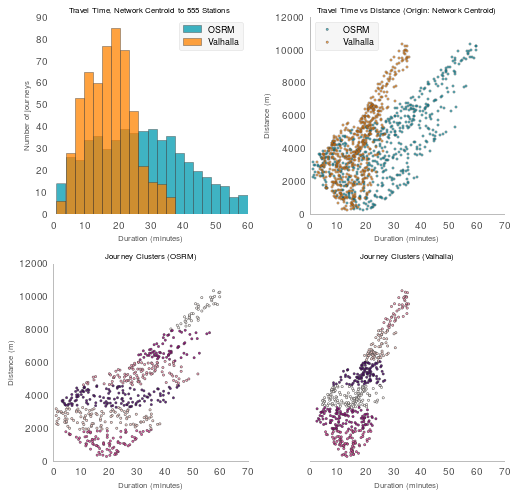

In [42]:
# set up plots
# numrows, numcolumns, plot number (specify in row, column order)
dotsize = 5.
linewidth = .5
fontsize=8

plt.clf()
fig = plt.figure(figsize=(7.28, 7.))

# Left-hand plot
ax = fig.add_subplot(221, axisbg='w', frame_on=False)
hist = merged[['travel_time_osrm', 'travel_time_valhalla']].plot(
    ax=ax,
    kind='hist',
    color=["#009aaf", "#ff8300"],
    edgecolor='#333333',
    bins=21,
    alpha=0.75)

plt.title(
    "Travel Time, Network Centroid to %s Stations" % len(merged),
    fontsize=8
)

ax.set_xlabel('Duration (minutes)', fontsize=fontsize)
ax.set_ylabel('Number of journeys', fontsize=fontsize)
leg = ax.legend(['OSRM', 'Valhalla'], fontsize=9)
leg.get_frame().set_alpha(0.5)
ax.grid(b=False)

# Right-hand plot
ax2 = fig.add_subplot(222, axisbg='none')

osrm = plt.scatter(
    x=merged['travel_time_osrm'],
    y=merged['centroid_distance'],
    marker='o',
    color="#009aaf",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

valhalla = plt.scatter(
    x=merged['travel_time_valhalla'],
    y=merged['centroid_distance'],
    marker='o',
    color="#ff8300",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

leg = plt.legend(
    (osrm, valhalla),
    ('OSRM',
    'Valhalla'),
    scatterpoints=1,
    fontsize=9,
    loc='upper left')
leg.get_frame().set_alpha(0.5)

plt.title(
    "Travel Time vs Distance (Origin: Network Centroid)",
    fontsize=8
)

ax2.set_xlabel('Duration (minutes)', fontsize=fontsize)
ax2.set_ylabel('Distance (m)', fontsize=fontsize)
ax2.grid(b=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim(0, 70)
ax2.set_ylim(0, 12000)

# Bottom left-hand plot
ax3 = fig.add_subplot(223, axisbg='w', frame_on=True)

osrm_cluster = plt.scatter(
    x=merged['travel_time_osrm'],
    y=merged['centroid_distance'],
    c=merged['cluster_id_osrm'],
    marker='o',
    color="#ff8300",
    cmap='RdPu',
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.85)

plt.title(
    "Journey Clusters (OSRM)",
    fontsize=8
)

ax3.set_xlabel('Duration (minutes)', fontsize=fontsize)
ax3.set_ylabel('Distance (m)', fontsize=fontsize)
ax3.grid(b=False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(0, 70)
ax3.set_ylim(0, 12000)

# Botom right-hand plot
ax4 = fig.add_subplot(224, axisbg='w', frame_on=True)

valhalla_cluster = plt.scatter(
    x=merged['travel_time_valhalla'],
    y=merged['centroid_distance'],
    c=merged['cluster_id_valhalla'],
    marker='o',
    color="#ff8300",
    cmap='RdPu',
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.85)

ax4.set_xlim(0, 70)
ax4.set_ylim(0, 12000)
plt.title(
    "Journey Clusters (Valhalla)",
    fontsize=8
)

ax4.set_xlabel('Duration (minutes)', fontsize=fontsize)
# ax4.set_ylabel('Distance (m)', fontsize=fontsize)
ax4.set_yticklabels([])
ax4.grid(b=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Save etc
plt.tight_layout()
plt.savefig(
    'combined.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=300)

plt.show()

As is obvious from the histogram and plot, the journey times and their distribution vary significantly between the two routers; Valhalla thinks you can get to any station in just over 35 minutes, with the majority taking 15–20 minutes. OSRM's journey times are far more evenly distributed, and greater in duration. [Most](https://twitter.com/mapzen/status/626080158890479620) (though [not all](https://twitter.com/mapzen/status/626083924192690176)) of the variation in duration is explained by Valhalla's default cycle speed of **25kph**, versus OSRM's **15kph**. When cycling speed and other costing options become available in the API, it'll be much easier to make more nuanced comparisons.

In [ ]:
# plot centroids (we aren't, currently)

plt.clf()
plt.figure(1)
plt.scatter(centroids_osrm[:, 0], centroids_osrm[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)